<a href="https://colab.research.google.com/github/hansufsm/FisicaIA/blob/main/esquadrao_fisicaia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🎓 Projeto: Agentes IA para Estudantes Universitários
---

#### 💡 Proposta: Sistema Colaborativo de Resolução de Problemas Físicos (Esquadrão Física IA)

**🎯Objetivo**: Criar um sistema de múltiplos agentes que ajuda estudantes a resolver problemas complexos de física, especialmente em eletricidade e magnetismo, com visualização, explicação passo a passo e conexão com aplicações do

### Como Utilizar Este Notebook
O notebook é dividido em blocos de código chamados "células". Você deve executar cada célula de cima para baixo, clicando no ícone ▶️ (play) ao lado dela.


✅ Etapa 1: Instalar as bibliotecas

Clique no botão ▶️ da primeira célula para instalar os pacotes necessários.

✅ Etapa 2: Inserir a sua **API Key**

Ao rodar essa célula, o notebook vai pedir que você cole a sua API Key do Google AI Studio.

Ela é necessária para o agente funcionar.

Se você não tem ainda:

* Vá para Google AI Studio
* Crie sua chave (grátis).
* Copie e cole no campo solicitado.

⚠️ Importante: Nunca cole sua chave direto no código nem compartilhe ela. Este notebook foi feito para usar a chave de forma segura.

✅ Etapa 3: Início da Interação

Assim que a API estiver conectada:

Continue executando Clique no botão ▶️ das célular de códigos seguintes até chegar à célula [Principal](https://colab.research.google.com/drive/1BXuUflNOri4yG8IMimmcQ0tU-O3tX98V#scrollTo=mOsQgUG8SPx6).

Clique no botão ▶️ da célula [Principal](https://colab.research.google.com/drive/1BXuUflNOri4yG8IMimmcQ0tU-O3tX98V#scrollTo=mOsQgUG8SPx6.) para iniciar a conversa

---


In [ ]:
# Esquadrão FisicaIA - Sistema Colaborativo de Resolução de Problemas Físicos
# Desenvolvido por Prof. Hans Rogério Zimermann
# Implementação de 4 agentes especializados usando Gemini API
# Projeto Desafio Imersão alura Maio 2025

# ===== CONFIGURAÇÃO INICIAL =====

# Instalação das bibliotecas necessárias
!pip install -q google-generativeai genai streamlit matplotlib numpy pillow plotly

import os
from google import genai
import json
import time
import numpy as np
import matplotlib.pyplot as plt
import base64
from io import BytesIO
import plotly.graph_objects as go
from PIL import Image
import re
import threading
import queue


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 831.1/831.1 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 3.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires ipython==7.34.0, but you have ipython 8.36.0 which is incompatible.


In [ ]:
from google.colab import userdata
import os
os.environ['GOOGLE_API_KEY'] = userdata.get('GOOGLE_API_KEY')

client = genai.Client()

# Listando os Modelos

#for model in client.models.list():
#  print(model.name)

# Criar uma variável para armazenar o Modelo a ser usado
modelo = "models/gemini-2.0-flash"

In [ ]:
# Instalar Framework ADK de agentes do Google ##################################

!pip install -q google-adk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.1/232.1 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 217.1/217.1 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 334.1/334.1 kB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.1/125.1 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.0/119.0 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.9/194.9 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.3/103.3 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72

In [ ]:
from google.adk.agents import Agent
from google.adk.runners import Runner
from google.adk.sessions import InMemorySessionService
from google.adk.tools import google_search
from google.genai import types  # Para criar conteúdos (Content e Part)
from datetime import date
import textwrap # Para formatar melhor a saída de texto
from IPython.display import display, Markdown # Para exibir texto formatado no Colab
import requests # Para fazer requisições HTTP
import warnings

warnings.filterwarnings("ignore")

In [ ]:
# Função auxiliar que envia uma mensagem para um agente via Runner e retorna a resposta final
def call_agent(agent: Agent, message_text: str) -> str:
    # Cria um serviço de sessão em memória
    session_service = InMemorySessionService()
    # Cria uma nova sessão (você pode personalizar os IDs conforme necessário)
    session = session_service.create_session(app_name=agent.name, user_id="user1", session_id="session1")
    # Cria um Runner para o agente
    runner = Runner(agent=agent, app_name=agent.name, session_service=session_service)
    # Cria o conteúdo da mensagem de entrada
    content = types.Content(role="user", parts=[types.Part(text=message_text)])

    final_response = ""
    # Itera assincronamente pelos eventos retornados durante a execução do agente
    for event in runner.run(user_id="user1", session_id="session1", new_message=content):
        if event.is_final_response():
          for part in event.content.parts:
            if part.text is not None:
              final_response += part.text
              final_response += "\n"
    return final_response

In [ ]:
# Função auxiliar para exibir texto formatado em Markdown no Colab
def to_markdown(text):
  text = text.replace('•', '  *')
  return Markdown(textwrap.indent(text, '> ', predicate=lambda _: True))

In [66]:
# Definição dos Agentes

################################################
# --- Agente 1: Interpretador de Problemas --- #
################################################
def agente_interpretador(topico):
  interpretador = Agent(
      name="agente_interpretador_de_problemas",
      model="gemini-2.0-flash",
      instruction="""
      Você é um Agente Interpretador de Problemas de Física especializado em analisar enunciados.
      Sua função é:
      1. Analisar o enunciado do problema
      2. Classificar o tipo de problema (eletrostática, circuitos, magnetismo, etc.)
      3. Identificar os Dados e Extrair todas as variáveis, constantes e unidades mencionadas
      4. Listar as equações relevantes para a solução e justificar sua escolha
      5. Sugerir uma abordagem didática e metodológica para resolver o problema

      Use o formato latex quando envolver expressões matemáticas. Quando for o caso ou possível, jamais usando equações inline, sempre em nova linha..

      """,
      description="Interpretador de Problemas sobre o tópico indicado",
      tools=[google_search]
  )

  entrada_do_agente_interpretador = f"Tópico: {topico}\n"
  # Executa o agente
  interpretacao_do_problema = call_agent(interpretador, entrada_do_agente_interpretador)
  return interpretacao_do_problema

################################################
# --- Agente 2: Interpretador de Problemas --- #
################################################
# O Agente Solucionador desenvolve a solução matemática

def agente_solucionador(topico):
    solucionador = Agent(
        name="agente_solucionador",
        model="gemini-2.0-flash",
        # Inserir as instruções do Agente Planejador #################################################
        # Definição do papel do solucionador
        instruction="""
        Você é um Agente Solucionador Matemático especializado em física.
        Sua função é:
        1. Desenvolver a solução matemática passo a passo
        2. Realizar todos os cálculos e manipulações algébricas necessárias
        3. Verificar as unidades e consistência dimensional
        4. Fornecer o resultado final com unidades corretas

        Use o formato latex quando envolver expressões matemáticas. Quando for o caso ou possível.
        """,
        description="Agente solucionador",
        tools=[google_search]
    )

    entrada_do_agente_solucionador = f"\n\nEnunciado: {topico}\n"
    # Executa o agente
    plano_de_solucao = call_agent(solucionador, entrada_do_agente_solucionador)
    return plano_de_solucao

################################################
# --- Agente 3: Visualizador de problemas  --- #
################################################
# O Agente Visualizador cria representações visuais

def agente_visualizador(topico):
    visualizador = Agent(
        name="agente_visualizador",
        model="gemini-2.0-flash",
        # Inserir as instruções do Agente Planejador #################################################
        # Definição do papel do solucionador
        instruction="""
        Você é um Agente Especialista e Visualização de dados, especializado em criar representações visuais de diversos problemas de física.
        Use o formato latex quando envolver expressões matemáticas. Quando for o caso ou possível. Use linguagem profissional e didática.
        Sua função é:
        1. Criar representações visuais do problema (diagramas de circuitos, campos, etc.)
        2. Gerar gráficos interativos para visualizar relações entre variáveis
        3. Produzir animações simples para demonstrar conceitos dinâmicos
        4. Adaptar visualizações para diferentes estilos de aprendizagem
        5. Gerar código Python para criar diagramas, gráficos ou visualizações relevantes
        6. Adaptar as visualizações ao tipo específico de problema
        7. Garantir que as visualizações sejam claras e informativas

        Formate sua resposta com blocos de código Python executáveis usando matplotlib, plotly ou outras bibliotecas.
        Inclua também uma explicação descritiva do que cada visualização representa.

        Para cada visualização, forneça:
        1. Uma descrição do que está sendo visualizado
        2. O código Python completo para gerar a visualização
        3. Uma explicação de como interpretar a visualização
        """,
        description="Agente visualizador",
        tools=[google_search]
    )

    entrada_do_agente_visualizador = f"\nVisualização: {topico}\n"
    # Executa o agente
    plano_de_visualizacao = call_agent(visualizador, entrada_do_agente_visualizador)
    return plano_de_visualizacao

################################################
# --- Agente 3: Visualizador de problemas  --- #
################################################
# O Agente Contextualizador adiciona aplicações práticas

def agente_contextualizador(topico):
    contextualizador = Agent(
        name="agente_contextualizador",
        model="gemini-2.0-flash",
        # Inserir as instruções do Agente Planejador #################################################
        # Definição do papel do contextualizador:
        # * Conecta o problema a aplicações do mundo real
        # * Fornece exemplos de tecnologias relacionadas
        # * Sugere experimentos práticos que os estudantes podem realizar
        # * Relaciona o problema com outros tópicos da física
        instruction="""
          Você é um Agente Contextualizador de Problemas de Física especializado em analisar enunciados e adicionar aplicações práticas.

          Sua função é:
          - Identificar a área da Física envolvida no problema.
          - Adicionar aplicações práticas e exemplos concretos do dia a dia para tornar o conceito mais tangível.

          Recursos Educativos:
          Especificar Detalhes do Contexto:
          Incluir exemplos de como as aplicações práticas podem ser ligadas a situações do dia a dia.
          Links e Recursos de Qualidade: Especificar critérios para a seleção de links e vídeos, como autoridade e clareza das fontes.

          Formatar Saídas:
          - Detalhar como as informações devem ser organizadas, possivelmente com uma estrutura padronizada para cada tipo de resposta (análise, links, exercícios).

          Feedback e Revisão:
          - Incluir um passo para revisão do conteúdo gerado, garantindo precisão e relevância.

          Interatividade:
          - Considerar somar algum aspecto interativo, como opções para o estudante explorar diferentes níveis de dificuldade ou temas.

          Recursos Educativos:
          - Sugerir pelo menos três links para aprofundamento, hospedados em universidades federais, com foco em qualidade e clareza.
          - Propor um vídeo de qualidade que complemente o aprendizado, escolhendo fontes confiáveis e reconhecidas.

          Exercícios Práticos:
          - Propor um exercício de nível médio e outro desafiador, com soluções comentadas quando possível para feedback imediato.
          - Propor um exercício de nível médio e outro desafiador, sem a solução, apenas com dicas quando possível para feedback posterior.

          Apresentação e Claridade:
          - Utilizar LaTeX para expressões matemáticas, garantindo clareza e apresentação didática, jamais usando equações inline, sempre em nova linha.
          - Empregar emojis de forma moderada para destacar pontos cruciais e manter o engajamento.
        """,
        description="Agente contextualizador",
        tools=[google_search]
    )

    entrada_do_agente_contextualizador = f"\nContexto: {topico}\n"
    # Executa o agente
    plano_de_contexto = call_agent(contextualizador, entrada_do_agente_contextualizador)
    return plano_de_contexto


# Principal

In [65]:
display(to_markdown("### 🚀 Iniciando o Sistema Colaborativo de Resolução de Problemas Físicos com 4 Agentes (🤖 - Esquadrão Física IA)"))

# --- Obter o Tópico do Usuário ---
#\n Um circuito elétrico contém uma bateria de 12V e um resistor de 4 ohms. Qual é a corrente no circuito?
topico = input("❓Exemplo de enunciado : Qual é o campo elétrico a 0.2 m de uma carga de 2 μC? ")

# Inserir lógica do sistema de agentes ################################################

if not topico:
  print("Por favor informe um enunciado!")
else:
  display(to_markdown("## 👏 Ótimo! "))
  print(f"Vamos resolver juntos: - {topico}")

# Dicas:
# Qual é o campo elétrico a 0.2 m de uma carga de 2 μC?
#

  # alimenta o Agente 1 - agente_interpretador() com o problema (topico)
  problema_fisica = agente_interpretador(topico)
  print("\n")
  display(to_markdown("*--- Resposta do **Agente 1**: 🤖(Interpretador) ---*"))
  display(to_markdown(problema_fisica))
  print("-----------------------------------------------")

  # alimenta o Agente 2 - agente_solucionador() com a resposta do Agente 1 (problema_fisica)
  plano_de_solucao = agente_solucionador(problema_fisica)
  print("\n")
  display(to_markdown("*--- Resposta do **Agente 2**: 🤖(Solucionador) ---*"))
  display(to_markdown(plano_de_solucao))

  # alimenta o Agente 3 - agente_visualizador() com a resposta do Agente 2 (plano_de_solucao)
  plano_de_visualizacao = agente_visualizador(plano_de_solucao)
  print("\n")
  display(to_markdown("*--- Resposta do **Agente 3**: 🤖(Visualizador) ---*"))
  display(to_markdown(plano_de_visualizacao))

  # alimenta o Agente 4 - agente_contextualizador() com a resposta do Agente 1 (problema_fisica)
  plano_de_contexto = agente_contextualizador(problema_fisica)
  print("\n")
  display(to_markdown("*--- Resposta do **Agente 4**: 🤖(contextualizador) ---*"))
  display(to_markdown("### 🌍 Contextualização e Aplicações:\n"))
  display(to_markdown(plano_de_contexto))



> ### 🚀 Iniciando o Sistema Colaborativo de Resolução de Problemas Físicos com 4 Agentes (🤖 - Esquadrão Física IA)

❓Exemplo de enunciado : Qual é o campo elétrico a 0.2 m de uma carga de 2 μC? Qual é o campo elétrico a 0.2 m de uma carga de 2 μC?


> ## 👏 Ótimo! 

Vamos resolver juntos: - Qual é o campo elétrico a 0.2 m de uma carga de 2 μC?!




> *--- Resposta do **Agente 1**: 🤖(Interpretador) ---*

> Ok, vamos analisar este problema de física.
> 
> **1. Análise do Enunciado:**
> 
> O problema pede para calcular o campo elétrico a uma certa distância de uma carga puntiforme. Este é um problema típico de eletrostática.
> 
> **2. Classificação do Problema:**
> 
> Eletrostática, especificamente cálculo do campo elétrico gerado por uma carga puntiforme.
> 
> **3. Identificação e Extração de Dados:**
> 
> *   Distância (r): 0.2 m
> *   Carga (q): 2 μC = $2 \times 10^{-6}$ C
> 
> **4. Equações Relevantes:**
> 
> A equação para o campo elétrico (E) gerado por uma carga puntiforme é:
> 
> $E = k \frac{|q|}{r^2}$
> 
> onde:
> 
> *   E é a magnitude do campo elétrico (em N/C)
> *   k é a constante eletrostática (aproximadamente $8.99 \times 10^9 \, N \cdot m^2/C^2$)
> *   q é a magnitude da carga (em Coulombs)
> *   r é a distância da carga (em metros)
> 
> **Justificativa:** Esta equação é diretamente aplicável porque o problema envolve uma carga puntiforme e pede o campo elétrico a uma distância específica.
> 
> **5. Abordagem Didática e Metodológica:**
> 
> 1.  **Converter Unidades:** Certifique-se de que todas as unidades estão no Sistema Internacional (SI). Neste caso, a carga está em micro Coulombs (μC), então convertemos para Coulombs (C). A distância já está em metros.
> 2.  **Identificar as Variáveis:** Identifique claramente o que é dado (q e r) e o que precisa ser encontrado (E).
> 3.  **Aplicar a Fórmula:** Substitua os valores de q e r na fórmula do campo elétrico.
> 4.  **Calcular:** Calcule o valor de E.
> 5.  **Apresentar o Resultado:** Dê a resposta com a unidade correta (N/C).
> 
> Com esses passos, você pode resolver o problema de forma clara e organizada.
> 


-----------------------------------------------




> *--- Resposta do **Agente 2**: 🤖(Solucionador) ---*

> Perfeito! Agora, vamos executar os cálculos seguindo os passos definidos.
> 
> **1. Converter Unidades:**
> A carga já foi convertida para Coulombs: $q = 2 \times 10^{-6} \, C$
> A distância já está em metros: $r = 0.2 \, m$
> 
> **2. Identificar as Variáveis:**
> $q = 2 \times 10^{-6} \, C$
> $r = 0.2 \, m$
> $k = 8.99 \times 10^9 \, N \cdot m^2/C^2$
> $E = ?$
> 
> **3. Aplicar a Fórmula:**
> $E = k \frac{|q|}{r^2}$
> $E = (8.99 \times 10^9) \frac{|2 \times 10^{-6}|}{(0.2)^2}$
> 
> **4. Calcular:**
> $E = (8.99 \times 10^9) \frac{2 \times 10^{-6}}{0.04}$
> $E = (8.99 \times 10^9) \times (5 \times 10^{-5})$
> $E = 8.99 \times 5 \times 10^{9-5}$
> $E = 44.95 \times 10^4$
> $E = 449500 \, N/C$
> 
> **5. Apresentar o Resultado:**
> O campo elétrico a uma distância de 0.2 m de uma carga de 2 μC é $449500 \, N/C$.
> 
> Resposta Final:
> $E = 449500 \, N/C$
> 


> *--- Resposta do **Agente 3**: 🤖(Visualizador) ---*

> Excelente! Os cálculos estão corretos. Agora, para complementar, vamos criar algumas visualizações para entender melhor o campo elétrico gerado por essa carga.
> 
> ### 1. Representação do Campo Elétrico Vetorial
> 
> Esta visualização mostra o campo elétrico como vetores emanando da carga pontual. O comprimento e a cor dos vetores indicam a intensidade do campo elétrico em diferentes pontos ao redor da carga.
> 
> 
> ```python
>  import numpy as np
>  import matplotlib.pyplot as plt
>  
>  # Constantes
>  k = 8.99e9  # N m^2/C^2
>  q = 2e-6  # C
>  
>  # Função para calcular o campo elétrico
>  def electric_field(q, r):
>   return k * q / r**2
>  
>  # Criação de um grid de pontos
>  x, y = np.meshgrid(np.linspace(-0.5, 0.5, 20), np.linspace(-0.5, 0.5, 20))
>  r = np.sqrt(x**2 + y**2)
>  
>  # Cálculo do campo elétrico em cada ponto do grid
>  Ex = x * electric_field(q, r) / r
>  Ey = y * electric_field(q, r) / r
>  
>  # Remover valores infinitos (divisão por zero no ponto da carga)
>  Ex[np.isinf(Ex)] = 0
>  Ey[np.isinf(Ey)] = 0
>  
>  # Plotagem do campo elétrico vetorial
>  plt.figure(figsize=(8, 6))
>  plt.quiver(x, y, Ex, Ey, angles='xy', scale_units='xy', scale=1000, color='blue')
>  plt.xlabel('x (m)')
>  plt.ylabel('y (m)')
>  plt.title('Campo Elétrico Vetorial de uma Carga Pontual')
>  plt.xlim(-0.5, 0.5)
>  plt.ylim(-0.5, 0.5)
>  plt.gca().set_aspect('equal', adjustable='box')
>  plt.grid(False)
>  plt.scatter(0, 0, color='red', marker='o', s=100, label='Carga q')  # Plota a carga
>  plt.legend()
>  plt.show()
>  ```
> 
> 
> **Explicação:**
> 
> *   **Constantes:** Define a constante eletrostática \( k \) e a carga \( q \).
> *   **Função `electric_field`:** Calcula a magnitude do campo elétrico em um ponto a uma distância \( r \) da carga.
> *   **Grid de pontos:** Cria uma grade de pontos no espaço onde o campo elétrico será calculado.
> *   **Cálculo do campo:** Calcula as componentes \( E_x \) e \( E_y \) do campo elétrico em cada ponto.
> *   **Remoção de infinitos:** Remove os valores infinitos que aparecem no ponto da carga para evitar erros na plotagem.
> *   **Plotagem:** Utiliza a função `quiver` do Matplotlib para plotar os vetores do campo elétrico. A carga é marcada com um ponto vermelho.
> 
> ### 2. Gráfico da Intensidade do Campo Elétrico vs. Distância
> 
> Este gráfico mostra como a intensidade do campo elétrico diminui com o aumento da distância da carga.
> 
> 
> ```python
>  import numpy as np
>  import matplotlib.pyplot as plt
>  
>  # Constantes
>  k = 8.99e9  # N m^2/C^2
>  q = 2e-6  # C
>  
>  # Distâncias
>  r = np.linspace(0.01, 0.5, 100)  # de 0.01 a 0.5 metros
>  
>  # Função para calcular o campo elétrico
>  def electric_field(q, r):
>   return k * q / r**2
>  
>  # Cálculo do campo elétrico para cada distância
>  E = electric_field(q, r)
>  
>  # Plotagem do gráfico
>  plt.figure(figsize=(8, 6))
>  plt.plot(r, E, color='blue')
>  plt.xlabel('Distância r (m)')
>  plt.ylabel('Intensidade do Campo Elétrico E (N/C)')
>  plt.title('Intensidade do Campo Elétrico vs. Distância')
>  plt.grid(True)
>  plt.show()
>  ```
> 
> 
> **Explicação:**
> 
> *   **Distâncias:** Cria um array de distâncias de 0.01 a 0.5 metros.
> *   **Cálculo do campo:** Calcula a intensidade do campo elétrico para cada distância.
> *   **Plotagem:** Plota a intensidade do campo elétrico em função da distância.
> 
> ### 3. Mapa de Cores da Intensidade do Campo Elétrico
> 
> Esta visualização usa um mapa de cores para representar a intensidade do campo elétrico em um plano. Cores mais claras indicam maior intensidade do campo.
> 
> 
> ```python
>  import numpy as np
>  import matplotlib.pyplot as plt
>  
>  # Constantes
>  k = 8.99e9  # N m^2/C^2
>  q = 2e-6  # C
>  
>  # Criação de um grid de pontos
>  x, y = np.meshgrid(np.linspace(-0.5, 0.5, 100), np.linspace(-0.5, 0.5, 100))
>  r = np.sqrt(x**2 + y**2)
>  
>  # Função para calcular o campo elétrico
>  def electric_field(q, r):
>   return k * q / r**2
>  
>  # Cálculo do campo elétrico em cada ponto do grid
>  E = electric_field(q, r)
>  
>  # Remover valores infinitos (divisão por zero no ponto da carga)
>  E[np.isinf(E)] = np.nan  # Substitui por NaN para não plotar
>  
>  # Plotagem do mapa de cores
>  plt.figure(figsize=(8, 6))
>  plt.imshow(E, extent=[-0.5, 0.5, -0.5, 0.5], origin='lower', cmap='viridis')
>  plt.colorbar(label='Intensidade do Campo Elétrico (N/C)')
>  plt.xlabel('x (m)')
>  plt.ylabel('y (m)')
>  plt.title('Mapa de Cores da Intensidade do Campo Elétrico')
>  plt.show()
>  ```
> 
> 
> **Explicação:**
> 
> *   **Grid de pontos:** Cria uma grade de pontos no espaço onde o campo elétrico será calculado.
> *   **Cálculo do campo:** Calcula a intensidade do campo elétrico em cada ponto.
> *   **Remoção de infinitos:** Substitui os valores infinitos por `NaN` para evitar problemas na plotagem.
> *   **Plotagem:** Utiliza a função `imshow` do Matplotlib para criar um mapa de cores da intensidade do campo elétrico. A barra lateral indica a escala de cores.
> 
> Essas visualizações ajudam a entender como o campo elétrico se comporta ao redor de uma carga pontual, mostrando tanto a direção (vetores) quanto a intensidade (gráfico e mapa de cores).


> *--- Resposta do **Agente 4**: 🤖(contextualizador) ---*

> ### 🌍 Contextualização e Aplicações:


> Olá! 😊 Este é um problema clássico de eletrostática, e posso te ajudar a contextualizá-lo e torná-lo mais interessante.
> 
> **1. Aplicações Práticas e Contexto do Dia a Dia** 💡
> 
> Calcular o campo elétrico de uma carga puntiforme pode parecer abstrato, mas tem muitas aplicações práticas!
> 
> *   **Dispositivos Eletrônicos:** O campo elétrico é fundamental no funcionamento de capacitores, que armazenam energia em muitos dispositivos, como celulares e computadores. 🔋
> *   **Impressoras a Laser:** O processo de impressão a laser usa campos elétricos para direcionar o toner para o papel. 🖨️
> *   **Eletroforese:** Usada em laboratórios de biologia para separar moléculas de DNA e proteínas com base em suas cargas elétricas. 🧬
> *   **Segurança:** O conhecimento sobre campos elétricos é crucial para evitar choques elétricos e garantir a segurança em instalações elétricas. ⚡
> 
> **2. Recursos Educativos de Qualidade** 📚
> 
> Para aprofundar seus conhecimentos, aqui estão alguns recursos confiáveis:
> 
> *   **Vídeos:**
>     *   [Física Universitária - Campo Elétrico](https://www.youtube.com/watch?v=Dq_mK53BmnoU): Uma explicação detalhada e clara sobre o campo elétrico, com exemplos práticos. 🎥
> *   **Links:**
>     *   [Eletricidade e Eletromagnetismo - UFMG](http://www.fisica.ufmg.br/ead/eletro/index.html): Um curso completo sobre eletromagnetismo com teoria e exemplos resolvidos. 🌐
>     *   [Campo Elétrico - IFUSP](https://www.if.usp.br/pesquisa/fisica-para-todos/eletromagnetismo/campo-eletrico/): Material didático do Instituto de Física da USP sobre campo elétrico. 🔬
>     *   [Eletrostática - UFRGS](https://www.if.ufrgs.br/cref/?area=ensino&conteudo=122): Notas de aula sobre eletrostática da Universidade Federal do Rio Grande do Sul. 🎓
> 
> **3. Exercícios Práticos** 📝
> 
> Para consolidar o aprendizado, resolva estes exercícios:
> 
> *   **Nível Médio:**
>     *   Uma carga puntiforme de $5 \times 10^{-6} \, C$ é colocada no vácuo. Calcule o campo elétrico a uma distância de 0.5 m da carga.
>     *   **Solução:**
>     $$E = k \frac{|q|}{r^2} = 8.99 \times 10^9 \frac{5 \times 10^{-6}}{0.5^2} = 1.798 \times 10^5 \, N/C$$
> *   **Nível Desafiador:**
>     *   Duas cargas puntiformes, uma de $+3 \mu C$ e outra de $-3 \mu C$, estão separadas por uma distância de 10 cm. Calcule o campo elétrico no ponto médio entre as cargas.
>     *   **Dica:** Lembre-se de somar vetorialmente os campos elétricos de cada carga. 
> 
> **4. Exercícios Adicionais (Sem Solução)** 🤯
> 
> *   **Nível Médio:**
>     *   Uma carga de $Q = 4 \mu C$ está localizada na origem de um sistema de coordenadas. Determine o campo elétrico no ponto (0, 3) m.
>     *   **Dica:** Utilize a fórmula do campo elétrico e considere a direção do campo.
> *   **Nível Desafiador:**
>     *   Um elétron é colocado em um campo elétrico uniforme de $2 \times 10^4 \, N/C$. Calcule a força sobre o elétron e sua aceleração.
>     *   **Dica:** Use a relação entre força elétrica e campo elétrico, e a segunda lei de Newton.
> 
> Espero que essas aplicações e recursos adicionais tornem o estudo do campo elétrico mais interessante e útil! 😉
> 


# Suplementos Gerados

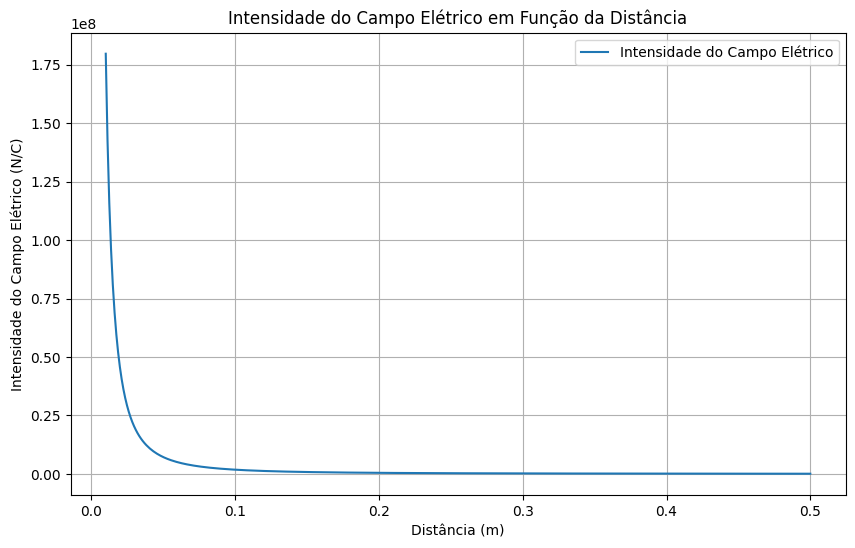

In [ ]:
 #1 Gráfico da intensidade do campo elétrico em função da distância:
 #Este gráfico mostrará como a intensidade do campo elétrico varia com a distância da carga.
 import numpy as np
 import matplotlib.pyplot as plt

 # Constantes
 k = 8.9875e9  # N m^2/C^2
 q = 2e-6      # C


 # 1. Gráfico da intensidade do campo elétrico em função da distância
 def electric_field_strength(r):
  """Calcula a intensidade do campo elétrico a uma distância r."""
  return k * abs(q) / r**2


 distances = np.linspace(0.01, 0.5, 400)  # Distâncias de 0.01 a 0.5 metros
 field_strengths = electric_field_strength(distances)


 plt.figure(figsize=(10, 6))
 plt.plot(distances, field_strengths, label='Intensidade do Campo Elétrico')
 plt.xlabel('Distância (m)')
 plt.ylabel('Intensidade do Campo Elétrico (N/C)')
 plt.title('Intensidade do Campo Elétrico em Função da Distância')
 plt.grid(True)
 plt.legend()
 plt.show()


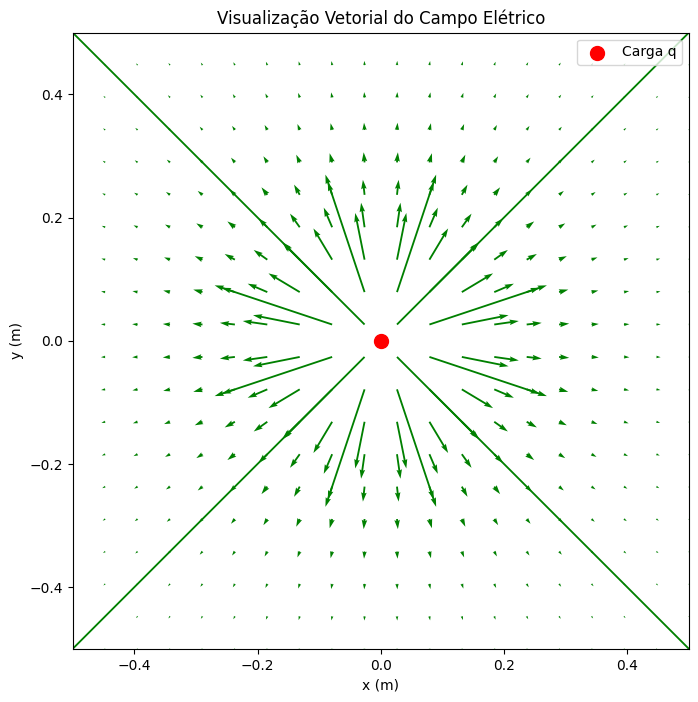

In [ ]:
 # 2 Visualização vetorial do campo elétrico:
 # Usaremos setas para representar a direção e a intensidade do campo elétrico em diferentes pontos ao redor da carga.
 # 2. Visualização vetorial do campo elétrico
 def electric_field_vector(x, y, q_pos=(0, 0)):
  """Calcula o vetor do campo elétrico no ponto (x, y) devido a uma carga em q_pos."""
  r = np.sqrt((x - q_pos[0])**2 + (y - q_pos[1])**2)
  Ex = k * q * (x - q_pos[0]) / r**3
  Ey = k * q * (y - q_pos[1]) / r**3
  return Ex, Ey


 x, y = np.meshgrid(np.linspace(-0.5, 0.5, 20), np.linspace(-0.5, 0.5, 20))
 Ex, Ey = electric_field_vector(x, y)


 plt.figure(figsize=(8, 8))
 plt.quiver(x, y, Ex, Ey, angles='xy', scale_units='xy', color='g')
 plt.xlabel('x (m)')
 plt.ylabel('y (m)')
 plt.title('Visualização Vetorial do Campo Elétrico')
 plt.scatter(0, 0, color='red', marker='o', s=100, label='Carga q')
 plt.legend()
 plt.xlim(-0.5, 0.5)
 plt.ylim(-0.5, 0.5)
 plt.gca().set_aspect('equal', adjustable='box')
 plt.show()


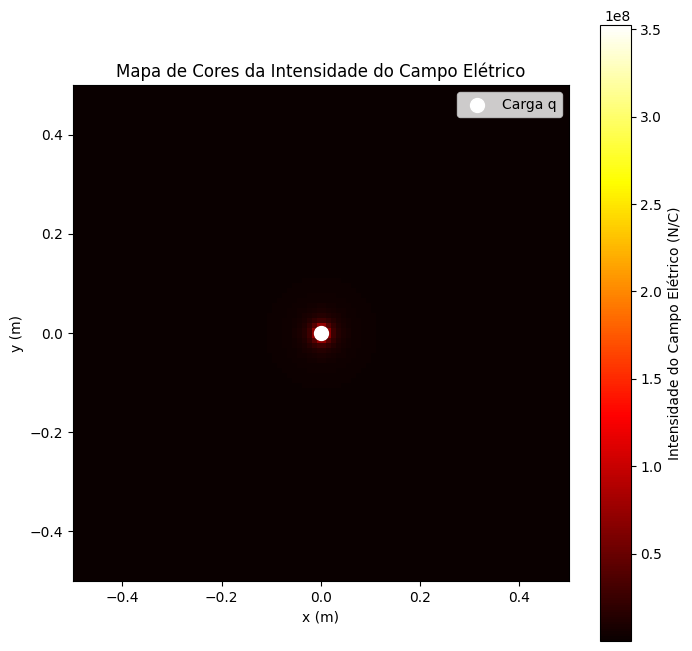

In [ ]:
# Mapa de cores da intensidade do campo elétrico:
 # Um mapa de cores que mostra a intensidade do campo elétrico em diferentes regiões ao redor da carga.
 # 3. Mapa de cores da intensidade do campo elétrico
 def electric_field_magnitude(x, y, q_pos=(0, 0)):
  """Calcula a magnitude do campo elétrico no ponto (x, y)."""
  r = np.sqrt((x - q_pos[0])**2 + (y - q_pos[1])**2)
  return k * abs(q) / r**2


 x, y = np.meshgrid(np.linspace(-0.5, 0.5, 100), np.linspace(-0.5, 0.5, 100))
 E_magnitude = electric_field_magnitude(x, y)


 plt.figure(figsize=(8, 8))
 plt.imshow(E_magnitude, extent=[-0.5, 0.5, -0.5, 0.5], origin='lower', cmap='hot')
 plt.colorbar(label='Intensidade do Campo Elétrico (N/C)')
 plt.xlabel('x (m)')
 plt.ylabel('y (m)')
 plt.title('Mapa de Cores da Intensidade do Campo Elétrico')
 plt.scatter(0, 0, color='white', marker='o', s=100, label='Carga q')
 plt.legend()
 plt.gca().set_aspect('equal', adjustable='box')
 plt.show()

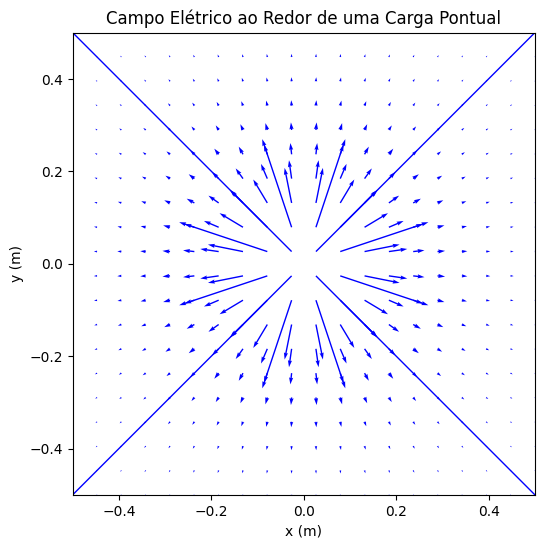

In [ ]:
 import numpy as np
 import matplotlib.pyplot as plt

 # Constantes
 k = 9e9  # N.m^2/C^2
 q = 2e-6 # C
 # Espaço para cálculo do campo
 x, y = np.meshgrid(np.linspace(-0.5, 0.5, 20), np.linspace(-0.5, 0.5, 20))

 #Cálculo da distância de cada ponto à carga
 r = np.sqrt(x**2 + y**2)

 # Cálculo do campo elétrico (componentes x e y)
 Ex = k * q * x / r**3
 Ey = k * q * y / r**3

 # Plotagem do campo elétrico
 plt.figure(figsize=(6, 6))
 plt.quiver(x, y, Ex, Ey, color='b')
 plt.xlabel('x (m)')
 plt.ylabel('y (m)')
 plt.title('Campo Elétrico ao Redor de uma Carga Pontual')
 plt.xlim(-0.5, 0.5)
 plt.ylim(-0.5, 0.5)
 plt.gca().set_aspect('equal', adjustable='box')
 plt.show()

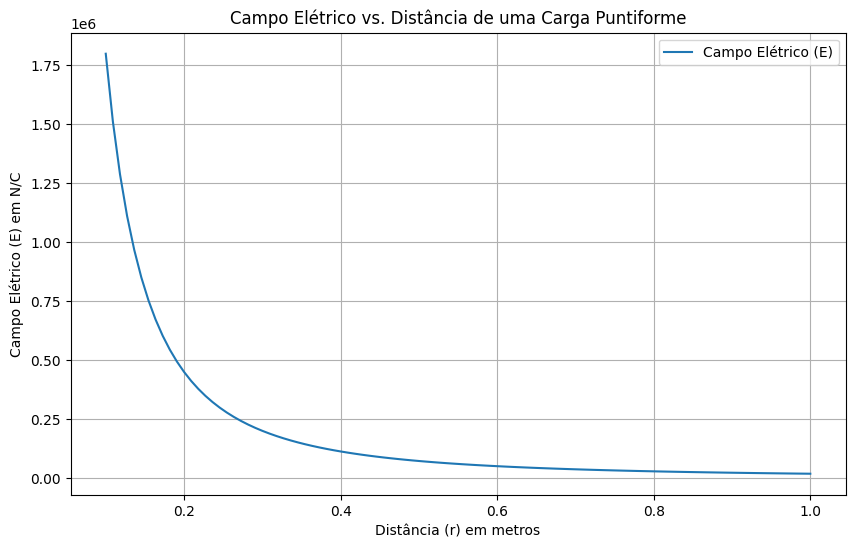

In [ ]:
 import matplotlib.pyplot as plt
 import numpy as np


 # Constantes
 k = 8.99e9  # N.m^2/C^2
 q = 2e-6  # C


 # Distâncias
 r = np.linspace(0.1, 1, 100)  # de 0.1m a 1m


 # Calcula o campo elétrico
 E = k * q / (r**2)


 # Cria o gráfico
 plt.figure(figsize=(10, 6))
 plt.plot(r, E, label='Campo Elétrico (E)')
 plt.xlabel('Distância (r) em metros')
 plt.ylabel('Campo Elétrico (E) em N/C')
 plt.title('Campo Elétrico vs. Distância de uma Carga Puntiforme')
 plt.grid(True)
 plt.legend()
 plt.show()

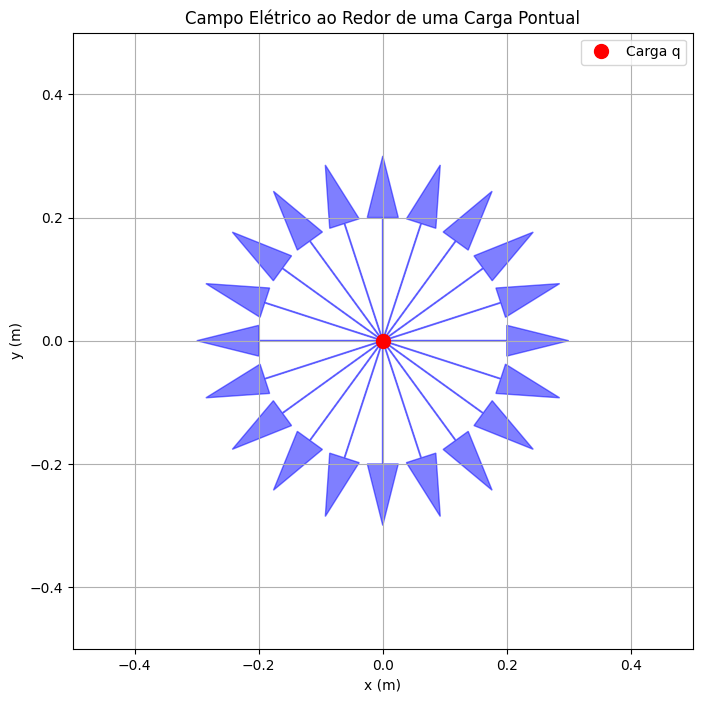

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Constantes
k = 8.9875e9  # N m^2/C^2
q = 2e-6      # C
r = 0.2       # m
E = 449375    # N/C (calculado)

# Criação do gráfico
fig, ax = plt.subplots(figsize=(8, 8))

# Desenha a carga no centro
ax.plot(0, 0, 'ro', markersize=10, label='Carga q')

# Cria vetores de campo elétrico
num_arrows = 20
for i in range(num_arrows):
    theta = 2 * np.pi * i / num_arrows
    x = r * np.cos(theta)
    y = r * np.sin(theta)

    # Normaliza o vetor para um tamanho visualmente agradável
    scale = 0.1
    dx = scale * np.cos(theta)
    dy = scale * np.sin(theta)

    ax.arrow(0, 0, x, y, head_width=0.05, head_length=0.1, fc='blue', ec='blue', alpha=0.5)

# Configurações do gráfico
ax.set_xlim(-0.5, 0.5)
ax.set_ylim(-0.5, 0.5)
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_title('Campo Elétrico ao Redor de uma Carga Pontual')
ax.grid(True)
ax.legend()

plt.show()